In [1]:
import pandas as pd
import numpy as np
import gensim as gs
import simplejson as json
import matplotlib.pyplot as plt

import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from collections import defaultdict
# from nltk import RegexpTokenizer

%matplotlib inline

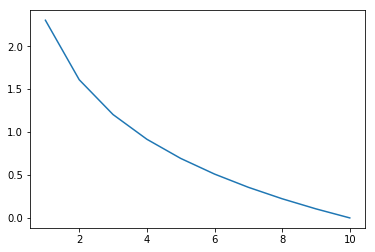

In [2]:
def idf(x):
    return np.log(10/x)

x = np.linspace(1,10,num=10)
plt.plot(x,idf(x))
plt.show()

In [3]:
class PreprocessIMDBData:
    def __init__(self):
        self.pattern = "[\w]+"
        self.stopword_set = set(stopwords.words('english'))
        
    def tokenizeSentence(self,text):
        tokenized_sentence = [w.lower() for w in nltk.regexp_tokenize(text,self.pattern)]
        cleanedSentence = list(set(tokenized_sentence).difference(self.stopword_set))
        return cleanedSentence

In [4]:
class VectorizeIMDBData:
    
    def __init__(self,tokenizerObj = PreprocessIMDBData()):
        self.tokenizerObj = tokenizerObj 
        self.tfidf = TfidfVectorizer(tokenizer=tokenizerObj.tokenizeSentence, ngram_range=(0, 1))
    
    def getTFIDFMatrix(self,docs):
        return self.tfidf.fit_transform(docs),self.tfidf.vocabulary_
    
    def getCleanedDocuments(self,docs, threshold = 0.6):
        scores,vocab = self.getTFIDFMatrix(docs)
        idf_inverse = 1/self.tfidf.idf_
        new_vocab_keys = (idf_inverse <= threshold)
        
        new_docs = []
        for doc_id,document in enumerate(docs):
            new_doc = []
            words = self.tokenizerObj.tokenizeSentence(document)
            for word in words:
                word_id  = vocab.get(word)
                if word_id is not None and new_vocab_keys[word_id]:
                    new_doc.append(word)
            
            cleanedDocument = ' '.join(new_doc)
            new_docs.append(cleanedDocument)
            
            del new_doc
        return new_docs
    
    def plot_words(self,threshold = [0.6]):
        max_figs_in_row = 5
        rows = int(np.ceil(len(threshold)/max_figs_in_row))
        cols  = np.minimum(len(threshold),max_figs_in_row)
        
        fig, axes = plt.subplots(rows, cols, figsize = (15, 9))
        
        vocab = self.tfidf.vocabulary_
        idf_inverse = 1/self.tfidf.idf_
        
        for i, ax in enumerate(fig.axes):
            frequencies = {}
            for key,value in vocab.items():
                if  value < len(idf_inverse) and idf_inverse[value] <= threshold[i]:
                    frequencies[key] = idf_inverse[value]
            
            if len(frequencies) <= 0:
                continue
            
            wc  = WordCloud(max_words=100)
            wc.generate_from_frequencies(frequencies)
            ax.imshow(wc, interpolation='bilinear')
            ax.set_axis_off()
        return

In [5]:
mytokenizer = PreprocessIMDBData()
myTfIdfGenerator = VectorizeIMDBData(mytokenizer)

                                            #################  Test tf-idf and tokenizer
# docs = ["The sun is shining allowance", "The sun weather is sweet", "the is shining and the weather is sweet"]
# cleaned_docs = myTfIdfGenerator.getCleanedDocuments(docs,threshold=0.8)
# print(cleaned_docs)

In [6]:
movies_actual = pd.read_csv('./the-movies-dataset/movies_metadata.csv',low_memory=False)
cols = ['id','title','genres','overview']
movies_df_clean = movies_actual[cols]
movies_df_clean = movies_df_clean[pd.notnull(movies_df_clean['overview'])]
movies_df_clean.info()
del movies_actual

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44512 entries, 0 to 45465
Data columns (total 4 columns):
id          44512 non-null object
title       44506 non-null object
genres      44512 non-null object
overview    44512 non-null object
dtypes: object(4)
memory usage: 1.7+ MB


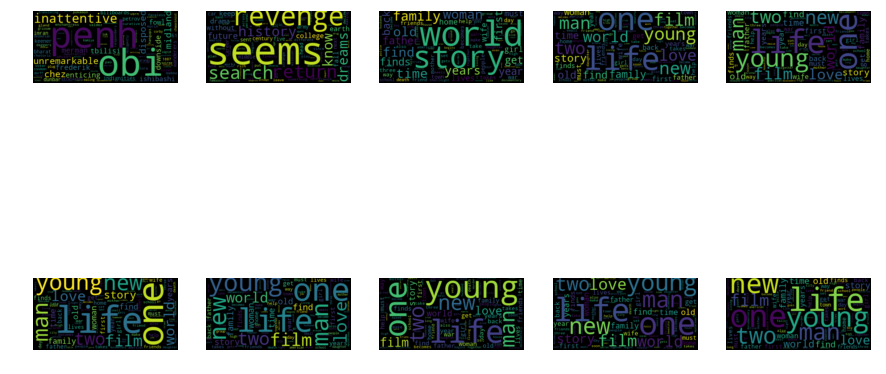

In [7]:
myTfIdfGenerator.getTFIDFMatrix(docs=list(movies_df_clean['overview']))
myTfIdfGenerator.plot_words(threshold=np.linspace(0.1,0.99,num=10))

In [8]:
overview_cleaned = myTfIdfGenerator.getCleanedDocuments(list(movies_df_clean['overview']), threshold = 0.6)
movies_df_clean['overview_cleaned'] = overview_cleaned

In [9]:
def plot_frequencies(movies_df_clean,cutoff = 0.00000001,columnName = 'overview',showGraph = False):
    mytokenizer = PreprocessIMDBData()
    genre_unkw = {}
    for index,row in movies_df_clean.iterrows():
        genresStr = row['genres']
        if pd.isnull(genresStr ):
            continue
        genreJson = json.loads(genresStr.replace("'",'"'))
        
        summary = set(mytokenizer.tokenizeSentence(row[columnName]))
        if len(summary) <= 0:
            continue
        
        for genreObject in genreJson:
            uniqueWords = set()
            if genreObject['name']  in genre_unkw:
                uniqueWords = genre_unkw[genreObject['name']]
            
            uniqueWords |= summary
            genre_unkw[genreObject['name']] = uniqueWords
            
    uniqueWordsSet = set()    
    uniqueWordsDict = {}
    for genre,uniqueWords in genre_unkw.items():
        uniqueGenreRep_Count = len(uniqueWords)
        uniqueWordsSet |= uniqueWords
        if uniqueGenreRep_Count <= cutoff * len(movies_df_clean):
            continue
        
        uniqueWordsDict[genre] = uniqueGenreRep_Count
        uniqueWordsDict['VocabSize'] = len(uniqueWordsSet)
        
    df = pd.DataFrame.from_dict(uniqueWordsDict, orient='index')
    if showGraph:
        df.plot(kind='bar')
    
    del uniqueWordsDict
    del genre_unkw
    return df

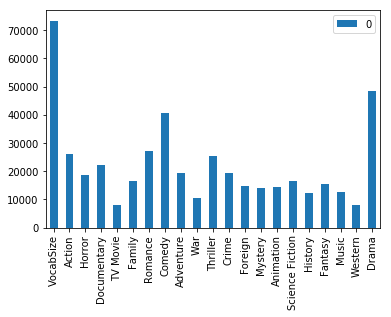

In [10]:
df = plot_frequencies(movies_df_clean,cutoff = 0.1,showGraph=True)

In [11]:
thresholds=np.linspace(0.1,0.99,num=10)

plots_list = list()
for threshold in thresholds:
    print("Analyzing for threshold ",threshold)
    overview_cleaned = myTfIdfGenerator.getCleanedDocuments(list(movies_df_clean['overview']), threshold = threshold)
    movies_df_clean['overview_cleaned'] = overview_cleaned
    df = plot_frequencies(movies_df_clean,cutoff=0.1,columnName='overview_cleaned')
    plots_list.append(df)
    print("Done with analysis")
print("------------->Done<-------------")

Analyzing for threshold  0.1
Done with analysis
Analyzing for threshold  0.198888888889
Done with analysis
Analyzing for threshold  0.297777777778
Done with analysis
Analyzing for threshold  0.396666666667
Done with analysis
Analyzing for threshold  0.495555555556
Done with analysis
Analyzing for threshold  0.594444444444
Done with analysis
Analyzing for threshold  0.693333333333
Done with analysis
Analyzing for threshold  0.792222222222
Done with analysis
Analyzing for threshold  0.891111111111
Done with analysis
Analyzing for threshold  0.99
Done with analysis
------------->Done<-------------


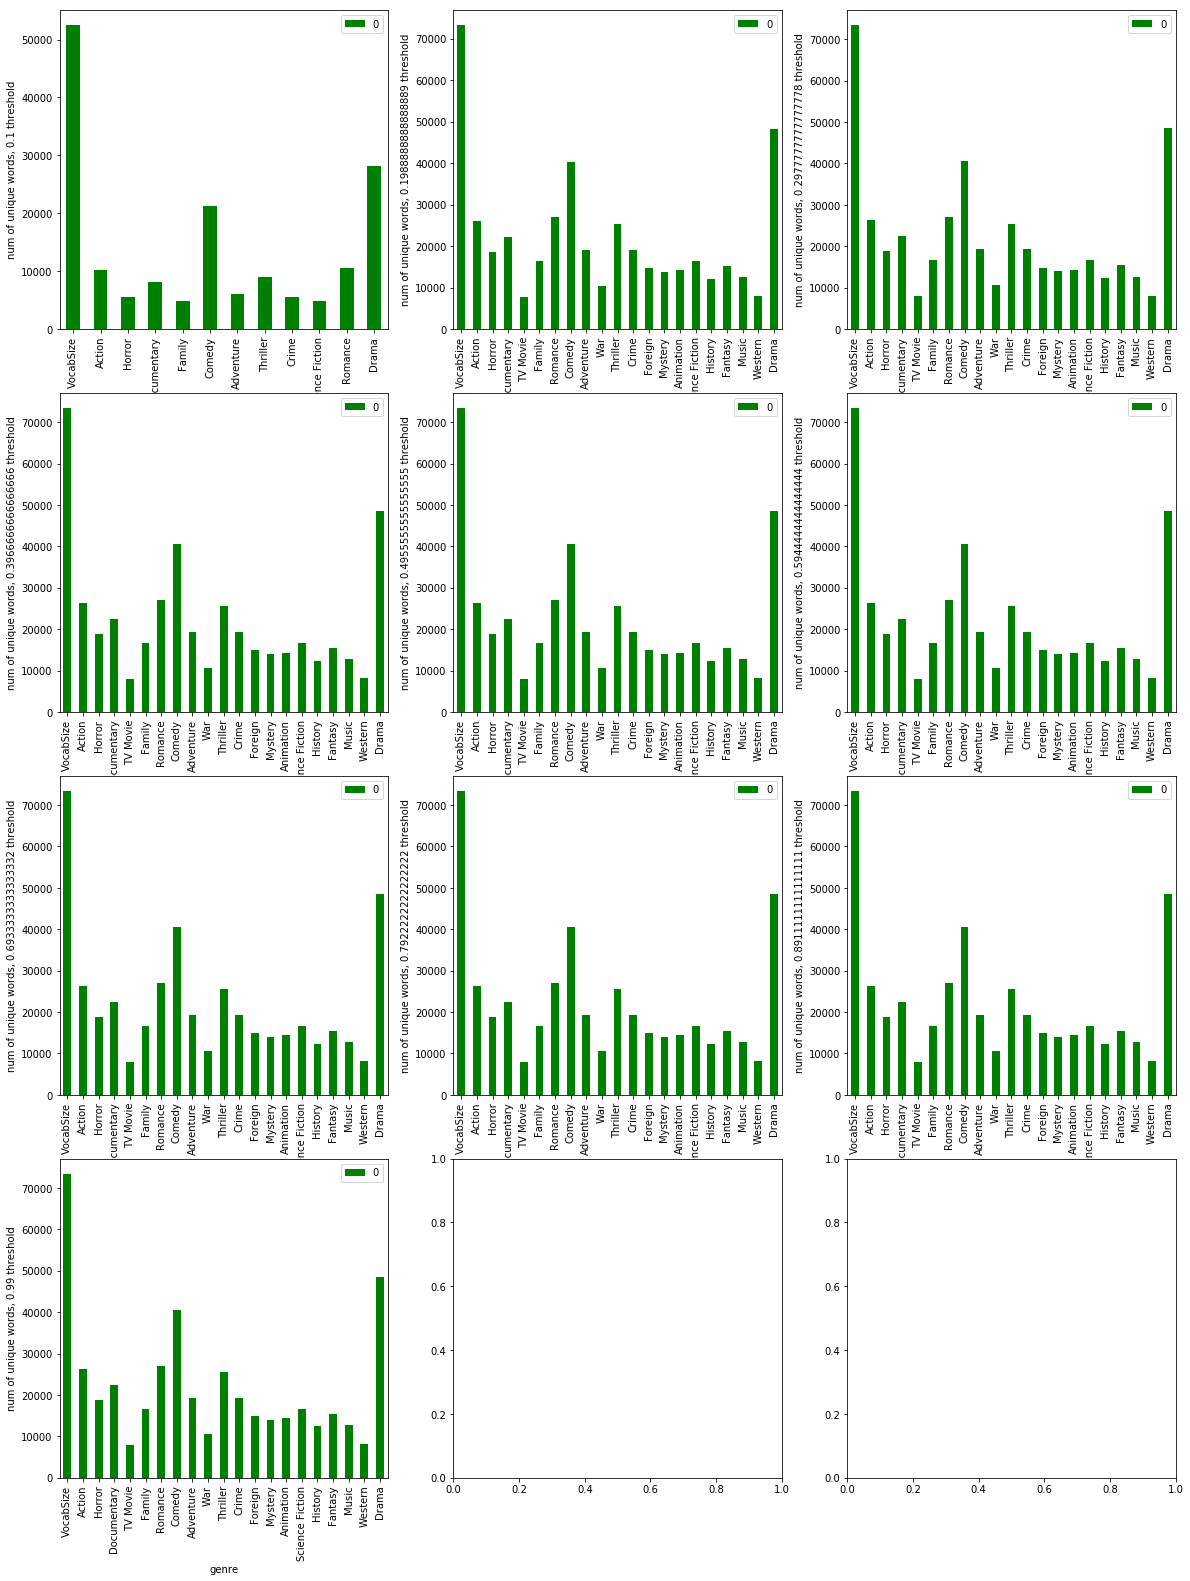

In [12]:
max_figs_in_row = 3
rows = int(np.ceil(len(plots_list)/max_figs_in_row))
cols  = np.minimum(len(plots_list),max_figs_in_row)

fig, axes = plt.subplots(rows, cols, figsize = (5*rows,9*cols))
for i, ax in enumerate(fig.axes):
    if i >= len(plots_list):
        continue
#     plots_list[i].plot(kind='bar',ax = ax)
    s = ['g' if index == 'VocabSize' else 'c' for index,value in plots_list[i][0].iteritems()]
    plots_list[i].plot(kind='bar',ax = ax,color = s)
    ax.set_xlabel("genre")
    ax.set_ylabel("num of unique words, {} threshold".format(thresholds[i]))

In [13]:
overview_cleaned = myTfIdfGenerator.getCleanedDocuments(list(movies_df_clean['overview']), threshold = 0.5)
movies_df_clean['overview_cleaned'] = overview_cleaned

# All genres have similar sentiments

In [14]:
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

In [15]:
class Utils:
    
    @staticmethod
    def getGenres(genresStr):
        if pd.isnull(genresStr ):
            return []
        
        genresInStrList = []
        genreJson = json.loads(genresStr.replace("'",'"'))
        for genreObject in genreJson:
            genreName = genreObject['name'].lower()
            genresInStrList.append(genreName)
        
        return genresInStrList

In [16]:
class LabeledIMDBData(object):
    
    def __init__(self,df):
        self.df = df
        self.tokenizer = PreprocessIMDBData()
        self.to_array()
    
    def __iter__(self):
        for movie_data in self.movies:
            yield movie_data
    
    def to_array(self):
        self.movies = []
        for index,row in self.df.iterrows():
            movietags = Utils.getGenres( row['genres'])
            movietags.append(row['id'])
            movietags.append(row['title'])
            self.movies.append(TaggedDocument(words = self.tokenizer.tokenizeSentence(row['overview_cleaned']),
                                              tags = movietags))
        return self.movies
    
    def generate_permutations(self):
        from random import shuffle
        shuffle(self.movies)
        return self
    
    def datasetSize(self):
        return len(self.movies)
    
    def getVocabFreq(self):
        vocab = {}
        for movie_info in self:
            overview = movie_info.words
            for word in overview:
                freq = 0
                if word in vocab:
                    freq = vocab[word]
                freq = freq + 1
                vocab[word] = freq
            
            tags = movie_info.tags
            for tag in tags:
                freq = 0
                if tag in vocab:
                    freq = vocab[tag]
                freq = freq + 1
                vocab[tag] =  freq
        return vocab
    
    def slice_tags(self,tagToSearch):
        movies = []
        
        for movie in self:
            tags = movie.tags
            for tag in tags:
                if tag == tagToSearch:
                    movies.append(movie)
        return movies
    
    def slice_text(self,wordToSearch):
        movies = []
        
        for movie in self:
            overview = movie_info.words
            for word in overview:
                if word == wordToSearch:
                    movies.append(movie)
        return movies
        

In [17]:
cores = 1
simple_models = [
    # PV-DM w/ concatenation - window=5 (both sides) approximates paper's 10-word total window size
    Doc2Vec(dm=1, dm_concat=1, size=100, window=5, negative=5, hs=0, min_count=2, workers=cores),
    # PV-DBOW 
    Doc2Vec(dm=0, size=100, negative=5, hs=0, min_count=1, workers=cores),
    # PV-DM w/ average
    Doc2Vec(dm=1, dm_mean=1, size=100, window=10, negative=5, hs=0, min_count=2, workers=cores),
]

In [18]:
movies_df_clean.head()

,id,title,genres,overview,overview_cleaned
0,862,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","Led by Woody, Andy's toys live happily in his ...",differences owner buzz lightyear duo aside toy...
1,8844,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",When siblings Judy and Peter discover an encha...,inside siblings opens monkeys finish running u...
2,15602,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",A family wedding reignites the ancient feud be...,sultry family hot alarming shop opens time coo...
3,31357,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","Cheated on, mistreated and stepped on, the wom...",talk glo bernie women string stellar lovers br...
4,11862,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]",Just when George Banks has recovered from his ...,banks recovered plan nina home kid change gran...


In [19]:
movies_data = LabeledIMDBData(movies_df_clean)  ## Small dataset
# movies_data = LabeledIMDBData(movies_df_clean)
model = Doc2Vec(dm=0, size=100, negative=5, hs=0, min_count=1, workers=cores)
# model.delete_temporary_training_data()
# model.build_vocab_from_freq(movies_data.getVocabFreq())
model.build_vocab(movies_data.to_array())
# model.raw_vocab

In [20]:
alpha, min_alpha, passes = (0.025, 0.001, 20)
alpha_delta = (alpha - min_alpha) / passes

for epoch in range(passes):
    print("Now at epoch number ",(epoch+1)," out of total number of epoch ",passes)
    
    model.alpha, model.min_alpha = alpha, alpha
    model.train(movies_data.generate_permutations(), total_examples=movies_data.datasetSize(), epochs=1)
    model.alpha -= alpha_delta
#     print(model.corpus_count)
    
    print("Done with epoch ")

Now at epoch number  1  out of total number of epoch  20
Done with epoch 
Now at epoch number  2  out of total number of epoch  20
Done with epoch 
Now at epoch number  3  out of total number of epoch  20
Done with epoch 
Now at epoch number  4  out of total number of epoch  20
Done with epoch 
Now at epoch number  5  out of total number of epoch  20
Done with epoch 
Now at epoch number  6  out of total number of epoch  20
Done with epoch 
Now at epoch number  7  out of total number of epoch  20
Done with epoch 
Now at epoch number  8  out of total number of epoch  20
Done with epoch 
Now at epoch number  9  out of total number of epoch  20
Done with epoch 
Now at epoch number  10  out of total number of epoch  20
Done with epoch 
Now at epoch number  11  out of total number of epoch  20
Done with epoch 
Now at epoch number  12  out of total number of epoch  20
Done with epoch 
Now at epoch number  13  out of total number of epoch  20
Done with epoch 
Now at epoch number  14  out of to

In [21]:
model.save('./models/imdb.d2v')
model.save_word2vec_format('./models/word2vecformat.nn')

In [22]:
doc_id = str(862)
sims = model.docvecs.most_similar(doc_id, topn=model.docvecs.count)  # get *all* similar documents
print(u'TARGET (%s): «%s»\n' % (doc_id, ' '.join(movies_data.slice_tags(doc_id)[0].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(movies_data.slice_tags(doc_id)[0].words)))

TARGET (862): «differences owner buzz lightyear duo aside toys eventually plots led scene heart losing woody happily place afraid learns brings live put onto birthday circumstances room andy separate»

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec(dbow,d100,n5,s0.001):

MOST ('Toy Story', 0.982749879360199): «differences owner buzz lightyear duo aside toys eventually plots led scene heart losing woody happily place afraid learns brings live put onto birthday circumstances room andy separate»

MEDIAN ('Salad Fingers', 0.2529734969139099): «differences owner buzz lightyear duo aside toys eventually plots led scene heart losing woody happily place afraid learns brings live put onto birthday circumstances room andy separate»

LEAST ('Afstiros katallilo', -0.22031539678573608): «differences owner buzz lightyear duo aside toys eventually plots led scene heart losing woody happily place afraid learns brings live put onto birthday circumstances room andy separate»



In [23]:
doc_id = ('animation')
sims = model.docvecs.most_similar(doc_id, topn=20)
sims

[('94205', 0.7986366152763367),
 ('Exaella', 0.7963681221008301),
 ('19004', 0.7086819410324097),
 ('The Land Before Time III: The Time of the Great Giving',
  0.7074610590934753),
 ('39961', 0.652421236038208),
 ('The Land Before Time XIII: The Wisdom of Friends', 0.63606196641922),
 ('10681', 0.6298931241035461),
 ('WALL·E', 0.6265134811401367),
 ('Escape from Planet Earth', 0.6204519271850586),
 ('31309', 0.6106308102607727),
 ('Steins;Gate: The Movie − Load Region of Déjà Vu', 0.6100839376449585),
 ('The Land Before Time IV: Journey Through the Mists', 0.607727587223053),
 ('65504', 0.6028608679771423),
 ('Chronopolis', 0.6018475294113159),
 ('24357', 0.6007495522499084),
 ('19164', 0.5989280939102173),
 ('12144', 0.5965211391448975),
 ('Final Flight of the Osiris', 0.5962817668914795),
 ('Pokémon: Destiny Deoxys', 0.5955826044082642),
 ('264646', 0.5955168008804321)]

In [24]:
doc_id = ('comedy')
sims = model.docvecs.most_similar(doc_id, topn=20)
sims

[('26884', 0.7694748640060425),
 ('Platinum Blonde', 0.752964973449707),
 ('romance', 0.7247167825698853),
 ("Norm Macdonald: Hitler's Dog, Gossip & Trickery", 0.5896385908126831),
 ('381276', 0.5856958627700806),
 ('Robin Williams - Off the Wall', 0.5829402208328247),
 ('I Think I Do', 0.580536425113678),
 ('456193', 0.577271044254303),
 ('19797', 0.5762083530426025),
 ('Trevor Noah: The Daywalker', 0.5757659673690796),
 ('drama', 0.5709115862846375),
 ('44637', 0.5687150359153748),
 ('Bridget Everett: Gynecological Wonder', 0.5681381225585938),
 ('265394', 0.5602339506149292),
 ('348601', 0.5599395036697388),
 ('Tracy Morgan: Bona Fide', 0.557016909122467),
 ('432959', 0.5545600652694702),
 ('Martin Lawrence: You So Crazy', 0.551653265953064),
 ('Josephine', 0.5507757663726807),
 ('217763', 0.5456879138946533)]

In [25]:
model.most_similar(['wedding','opens'])

/home/batman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':


[('younger', 0.4626690447330475),
 ('irshava', 0.4250844717025757),
 ('yoelson', 0.40987324714660645),
 ('grandong', 0.40902116894721985),
 ('sassaroli', 0.40699130296707153),
 ('marieke', 0.40592658519744873),
 ('terminals', 0.40152931213378906),
 ('parched', 0.3995184600353241),
 ('scoured', 0.3967169523239136),
 ('crater', 0.37415558099746704)]

In [26]:
model.docvecs.similarity('romance','animation')

0.22262901019329001

In [27]:
model.docvecs.similarity('drama','family')

0.24301944396687464

In [33]:
genres = set()
for idx,row in movies_df_clean.iterrows():
    genres |= set(Utils.getGenres(row['genres']))

genres = list(genres)

In [43]:
from itertools import permutations
for genreSublist in permutations(genres,2):
    genreOne = genreSublist[0]
    genreTwo = genreSublist[1]
    similarity_score = model.docvecs.similarity(genreOne,genreTwo)
    if similarity_score< 0.3:
        continue
    print("Similarity between %s,%s is %f\n" % (genreOne,genreTwo,similarity_score))

Similarity between western,war is 0.319450

Similarity between western,gohands is 0.389651

Similarity between western,thriller is 0.324722

Similarity between western,foreign is 0.323274

Similarity between western,odyssey media is 0.397629

Similarity between western,pulser productions is 0.373258

Similarity between western,crime is 0.355726

Similarity between western,the cartel is 0.403539

Similarity between western,carousel productions is 0.430574

Similarity between western,action is 0.443981

Similarity between western,rogue state is 0.408626

Similarity between western,vision view entertainment is 0.373105

Similarity between western,mystery is 0.428158

Similarity between western,brosta tv is 0.421732

Similarity between western,mardock scramble production committee is 0.437000

Similarity between western,telescene film group productions is 0.383278

Similarity between western,aniplex is 0.413015

Similarity between western,sentai filmworks is 0.426457

Similarity between we

In [64]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel

sentenceTokenizer = PreprocessIMDBData()
movies = movies_df_clean['overview_cleaned'].values
movie_tokenized = [sentenceTokenizer.tokenizeSentence(movie) for movie in movies]
dictionary = corpora.Dictionary(movie_tokenized)
doc_term_matrix = [dictionary.doc2bow(movie) for movie in movie_tokenized]

In [ ]:
ldamodel = LdaModel(doc_term_matrix,num_topics=10,id2word=dictionary,passes= 20,alpha=0.3,eta=0.7)

In [ ]:
print(ldamodel.print_topics(num_topics=10,num_words=3))